In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import files
uploaded = files.upload()


Saving heart.csv to heart (1).csv


In [3]:
import pandas as pd
df = pd.read_csv("heart.csv")

## Getting some insight about our data

In [4]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [5]:
df.dtypes

,0
age,int64
sex,int64
cp,int64
trestbps,int64
chol,int64
fbs,int64
restecg,int64
thalach,int64
exang,int64
oldpeak,float64


array([[<Axes: title={'center': 'age'}>, <Axes: title={'center': 'sex'}>,
        <Axes: title={'center': 'cp'}>,
        <Axes: title={'center': 'trestbps'}>],
       [<Axes: title={'center': 'chol'}>,
        <Axes: title={'center': 'fbs'}>,
        <Axes: title={'center': 'restecg'}>,
        <Axes: title={'center': 'thalach'}>],
       [<Axes: title={'center': 'exang'}>,
        <Axes: title={'center': 'oldpeak'}>,
        <Axes: title={'center': 'slope'}>,
        <Axes: title={'center': 'ca'}>],
       [<Axes: title={'center': 'thal'}>,
        <Axes: title={'center': 'target'}>, <Axes: >, <Axes: >]],
      dtype=object)

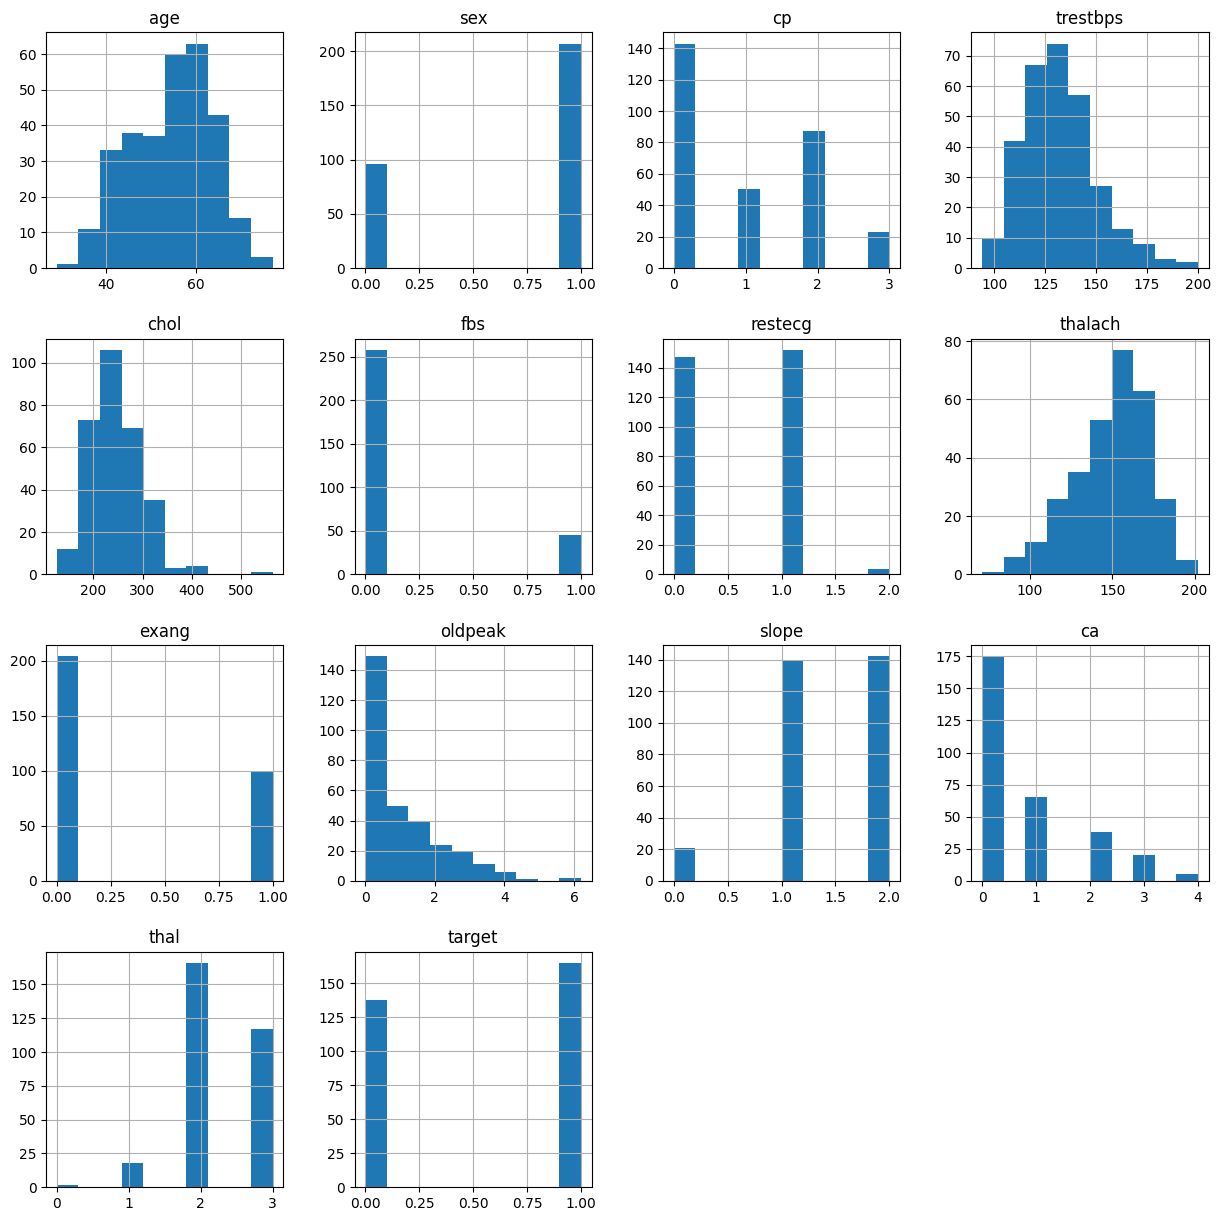

In [6]:
df.hist(figsize=(15,15))

We can see that the dataset contains few categorical features and few continuous features

<Axes: >

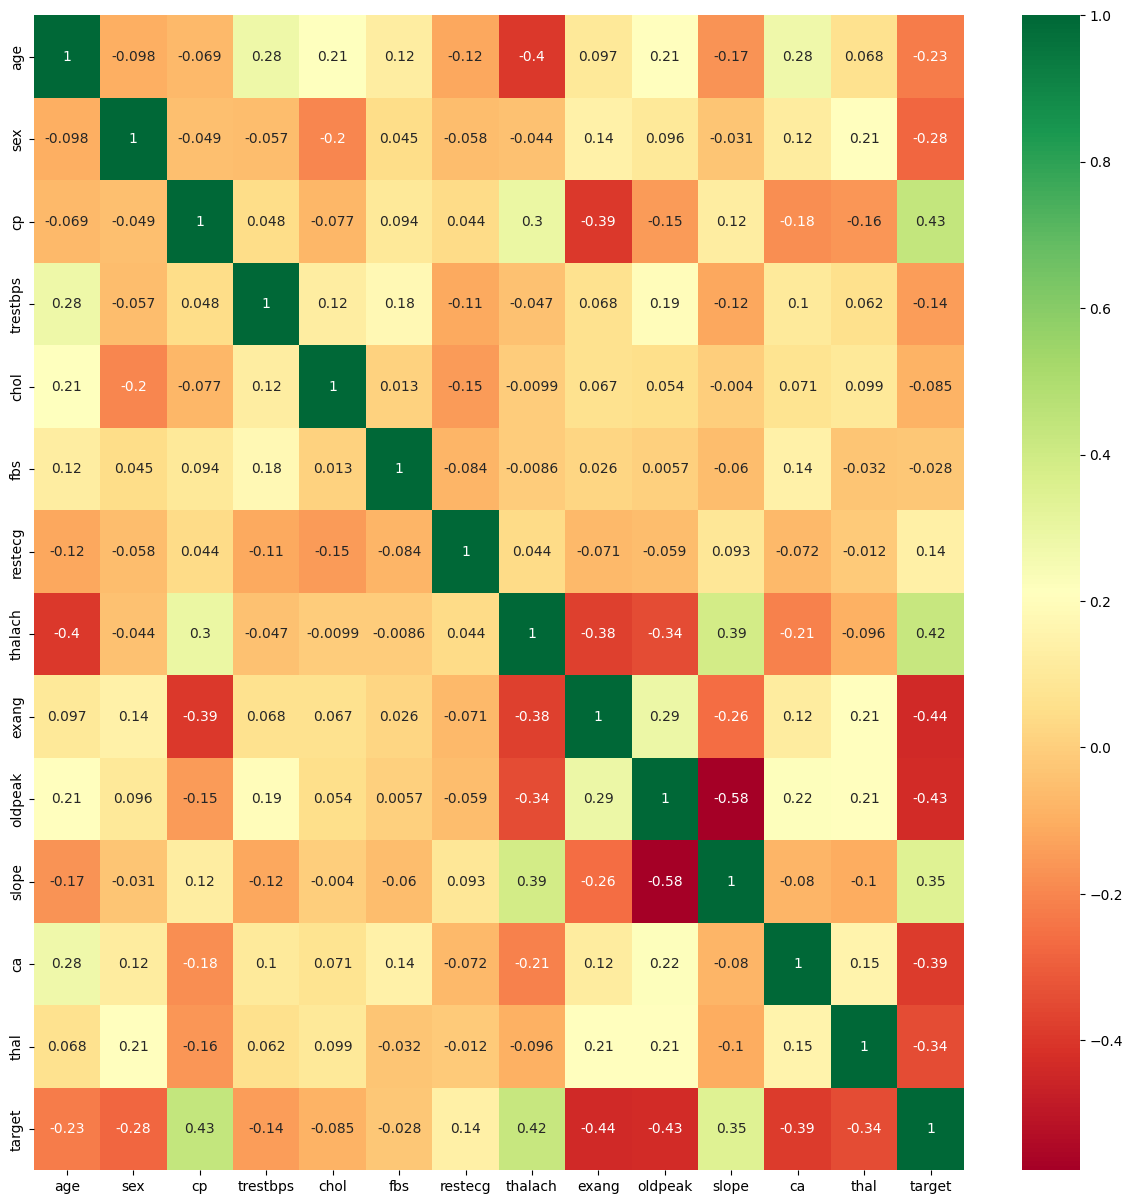

In [7]:
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(),annot=True,cmap='RdYlGn')

There are few features that have negative correlation with target and few with positive correlation

No disease:46.0%
Disease:54.0%


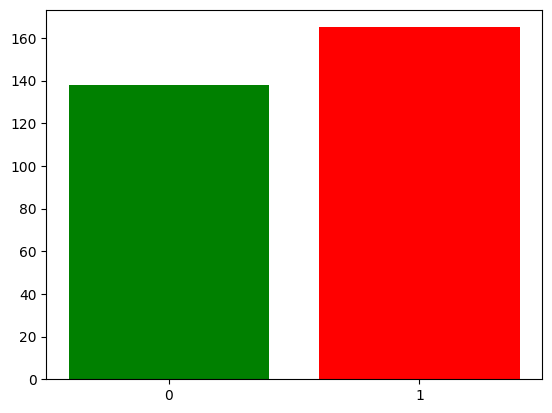

In [8]:
plt.bar(df.target.unique(),df.target.value_counts(),color=['red','green'])
plt.xticks([0,1])
print('No disease:{}%\nDisease:{}%'.format(round(df.target.value_counts(normalize=True)[0],2)*100,
                                           round(df.target.value_counts(normalize=True)[1],2)*100))

The two classes are not exactly 50% each but the ratio is good enough to continue without dropping/increasing our data.

## Data Preprocessing

In [9]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
column_trans = make_column_transformer(
                (OneHotEncoder(),['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']),
                (StandardScaler(),['age', 'trestbps', 'chol', 'thalach', 'oldpeak']),
                remainder = 'passthrough')

Applying OneHotEncoder on the categorical features and StandardScalar on continuous features

## Train Test Split

In [10]:
from sklearn.model_selection import train_test_split
X = df.drop(['target'], axis = 1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 0)

In [11]:
column_trans.fit_transform(X_train)

array([[ 1.        ,  0.        ,  1.        , ...,  0.82851175,
        -2.00163972,  0.66036428],
       [ 1.        ,  0.        ,  0.        , ...,  0.07503002,
         0.97945954, -0.91869649],
       [ 0.        ,  1.        ,  1.        , ...,  1.3308329 ,
        -1.8661352 ,  1.07590658],
       ...,
       [ 0.        ,  1.        ,  0.        , ..., -0.9834324 ,
         0.52777784,  0.66036428],
       [ 0.        ,  1.        ,  0.        , ...,  0.16473023,
         0.25676881, -0.91869649],
       [ 0.        ,  1.        ,  0.        , ...,  0.64911134,
         0.43744149,  0.57725581]])

## Classification Algorithms

### 1. Logistic Regression

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
logreg = LogisticRegression(solver='lbfgs')
pipe = make_pipeline(column_trans,logreg)

In [13]:
from sklearn.model_selection import cross_val_score
cross_val_score(pipe, X_train, y_train, cv=5, scoring='accuracy').mean()

np.float64(0.8621951219512194)

### 2. K Nearest Neighbors

In [14]:
from sklearn.neighbors import KNeighborsClassifier
knn_scores = []
for k in range(1,31):
    knn_classifier = KNeighborsClassifier(n_neighbors = k)
    pipe = make_pipeline(column_trans,knn_classifier)
    knn_scores.append(cross_val_score(pipe, X_train, y_train, cv=5, scoring='accuracy').mean())

Text(0.5, 1.0, 'K Neighbors Classifier scores for different K values')

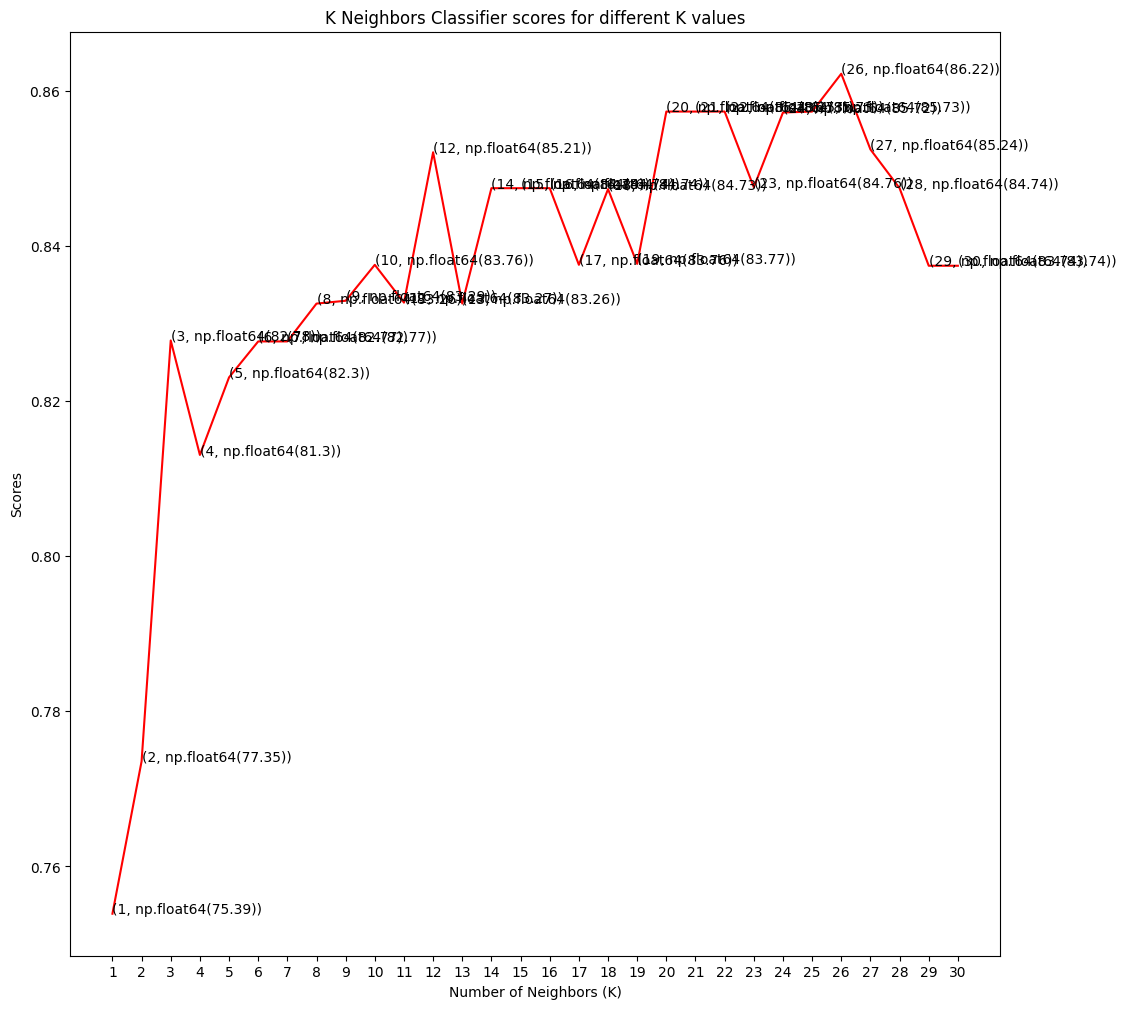

In [15]:
plt.figure(figsize=(12,12))
plt.plot([k for k in range(1, 31)], knn_scores, color = 'red')
for i in range(1,31):
    plt.text(i, knn_scores[i-1], (i, round(knn_scores[i-1]*100,2)))
plt.xticks([i for i in range(1, 31)])
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Scores')
plt.title('K Neighbors Classifier scores for different K values')

In [16]:
knn_scores[25]

np.float64(0.8621951219512196)

### 3. Support Vector Classifier (SVC)

There are several kernels for Support Vector Classifier. I'll test some of them and check which has the best score.

In [17]:
from sklearn.svm import SVC
svc_scores = []
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
for i in range(len(kernels)):
    svc_classifier = SVC(kernel = kernels[i])
    pipe = make_pipeline(column_trans,svc_classifier)
    svc_scores.append(cross_val_score(pipe, X_train, y_train, cv=5, scoring='accuracy').mean())

Text(0.5, 1.0, 'Support Vector Classifier scores for different kernels')

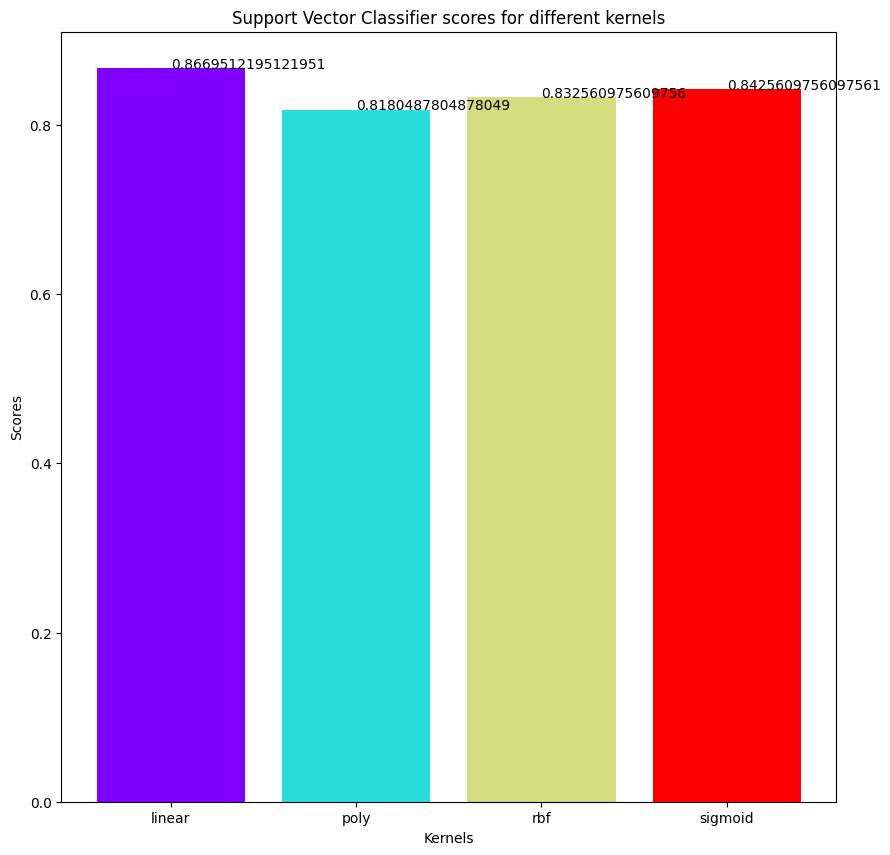

In [18]:
from matplotlib.cm import rainbow
colors = rainbow(np.linspace(0, 1, len(kernels)))
plt.figure(figsize=(10,10))
plt.bar(kernels, svc_scores, color = colors)
for i in range(len(kernels)):
    plt.text(i, svc_scores[i], svc_scores[i])
plt.xlabel('Kernels')
plt.ylabel('Scores')
plt.title('Support Vector Classifier scores for different kernels')

In [19]:
svc_scores[0] #linear

np.float64(0.8669512195121951)

### 4. Decision Tree Classifier

In [20]:
from sklearn.tree import DecisionTreeClassifier
dt_scores = []
for i in range(1, len(X.columns) + 1):
    dt_classifier = DecisionTreeClassifier(max_features = i, random_state = 0)
    pipe = make_pipeline(column_trans,dt_classifier)
    dt_scores.append(cross_val_score(pipe, X_train, y_train, cv=5, scoring='accuracy').mean())

Text(0.5, 1.0, 'Decision Tree Classifier scores for different number of maximum features')

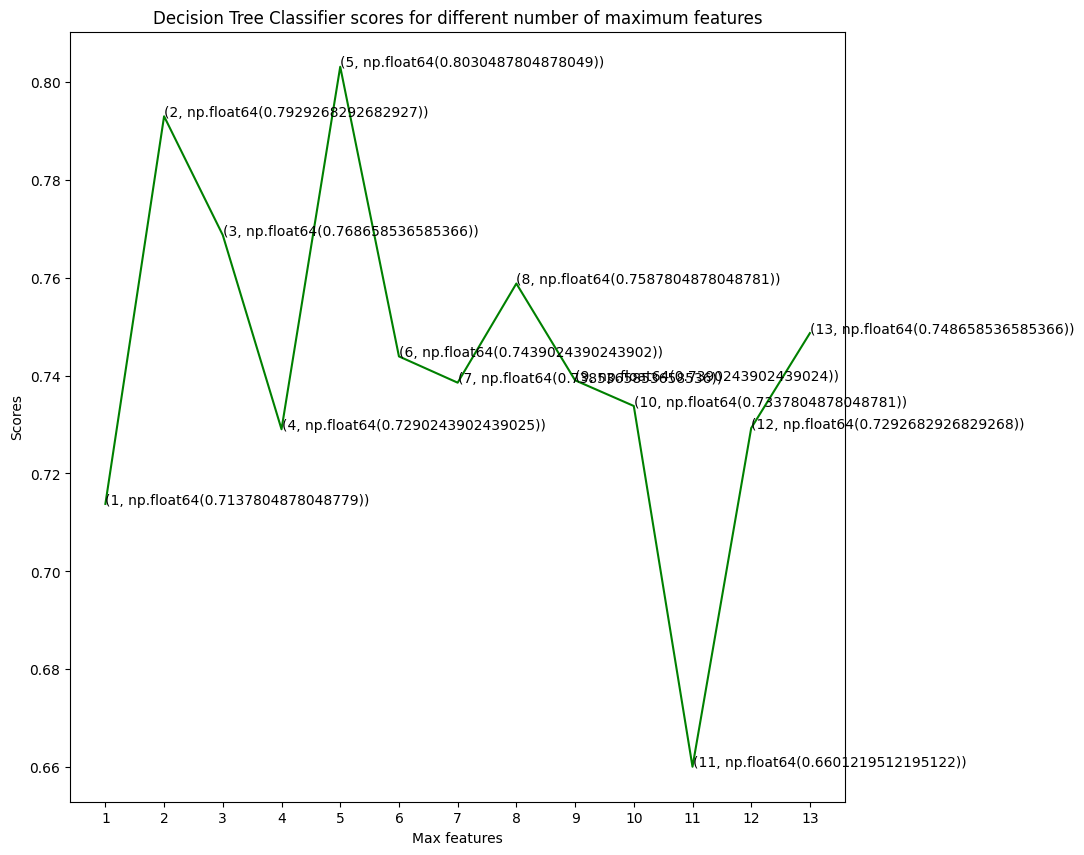

In [21]:
plt.figure(figsize=(10,10))
plt.plot([i for i in range(1, len(X.columns) + 1)], dt_scores, color = 'green')
for i in range(1, len(X.columns) + 1):
    plt.text(i, dt_scores[i-1], (i, dt_scores[i-1]))
plt.xticks([i for i in range(1, len(X.columns) + 1)])
plt.xlabel('Max features')
plt.ylabel('Scores')
plt.title('Decision Tree Classifier scores for different number of maximum features')

In [22]:
dt_scores[4]

np.float64(0.8030487804878049)

### 5. Random Forest Classifier

In [23]:
from sklearn.ensemble import RandomForestClassifier
rf_scores = []
estimators = [10, 100, 200, 500, 1000]
for i in estimators:
    rf_classifier = RandomForestClassifier(n_estimators = i, random_state = 0)
    pipe = make_pipeline(column_trans,rf_classifier)
    rf_scores.append(cross_val_score(pipe, X_train, y_train, cv=5, scoring='accuracy').mean())

Text(0.5, 1.0, 'Random Forest Classifier scores for different number of estimators')

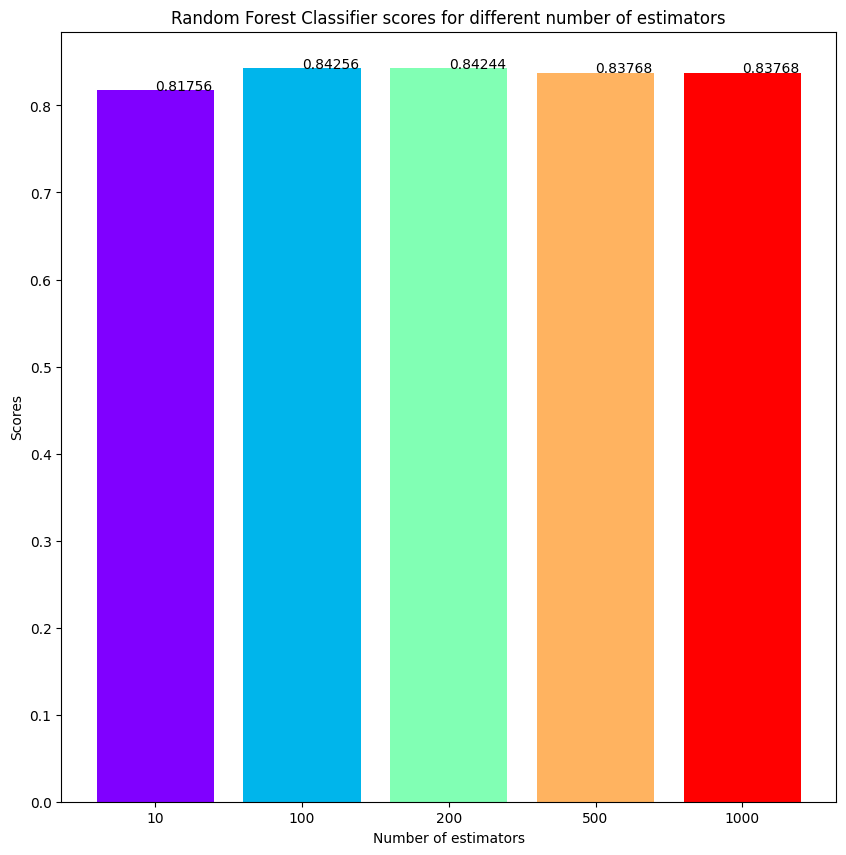

In [24]:
plt.figure(figsize=(10,10))
colors = rainbow(np.linspace(0, 1, len(estimators)))
plt.bar([i for i in range(len(estimators))], rf_scores, color = colors, width = 0.8)
for i in range(len(estimators)):
    plt.text(i, rf_scores[i], round(rf_scores[i],5))
plt.xticks(ticks = [i for i in range(len(estimators))], labels = [str(estimator) for estimator in estimators])
plt.xlabel('Number of estimators')
plt.ylabel('Scores')
plt.title('Random Forest Classifier scores for different number of estimators')

In [25]:
rf_scores[1]

np.float64(0.8425609756097561)

### 6. Gaussian NB

In [26]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
pipe = make_pipeline(column_trans,nb)
cross_val_score(pipe, X_train, y_train, cv=5, scoring='accuracy').mean()

np.float64(0.8082926829268293)

It is worth to test our data on 'testing dataset' using two classification models that are having high accuracy score than other classification models. They are (i) Logistic Regression and (ii) SVC using linear kernel.

## Make predictions on "unseen" data

### 1. Logistic Regression

In [27]:
pipe = make_pipeline(column_trans,logreg)
pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['sex', 'cp', 'fbs',
                                                   'restecg', 'exang', 'slope',
                                                   'ca', 'thal']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['age', 'trestbps', 'chol',
                                                   'thalach', 'oldpeak'])])),
                ('logisticregression', LogisticRegression())])

In [28]:
y_pred = pipe.predict(X_test)

In [29]:
from sklearn import metrics
metrics.accuracy_score(y_test,y_pred)*100

84.0

### 2. SVC with linear kernel

In [30]:
svc_classifier = SVC(kernel = 'linear')
pipe = make_pipeline(column_trans,svc_classifier)
pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['sex', 'cp', 'fbs',
                                                   'restecg', 'exang', 'slope',
                                                   'ca', 'thal']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['age', 'trestbps', 'chol',
                                                   'thalach', 'oldpeak'])])),
                ('svc', SVC(kernel='linear'))])

In [31]:
y_pred = pipe.predict(X_test)

In [32]:
from sklearn import metrics
metrics.accuracy_score(y_test,y_pred)*100

83.0

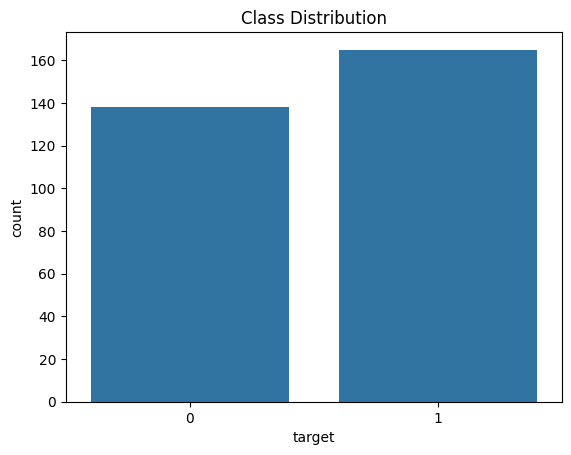

Class distribution: Counter({1: 165, 0: 138})
No significant class imbalance detected.


In [33]:
# class imbalance
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

# Visualizing class distribution
sns.countplot(x='target', data=df)
plt.title('Class Distribution')
plt.show()

# Checking class balance
counter = Counter(df['target'])
print("Class distribution:", counter)

X = df.drop('target', axis=1)
y = df['target']

imbalance_threshold = 0.4
minority_class_ratio = min(counter.values()) / sum(counter.values())

# Apply SMOTE only if class imbalance is significant
if minority_class_ratio < imbalance_threshold:
    print("Applying SMOTE...")
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
else:
    print("No significant class imbalance detected.")
    X_resampled, y_resampled = X, y


In [34]:
# Feature selection using mutual information
from sklearn.feature_selection import mutual_info_classif
import pandas as pd

# Computing mutual information scores
mi_scores = mutual_info_classif(X_resampled, y_resampled)
mi_scores_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

print("Mutual Information Scores:")
print(mi_scores_series)

# Selecting top N important features
top_features = mi_scores_series.head(10).index.tolist()
X_selected = X_resampled[top_features]


Mutual Information Scores:
cp          0.159296
thal        0.149893
exang       0.135061
ca          0.113623
oldpeak     0.084347
thalach     0.078408
sex         0.074767
chol        0.070824
slope       0.046465
age         0.009367
trestbps    0.006339
restecg     0.001901
fbs         0.000000
dtype: float64


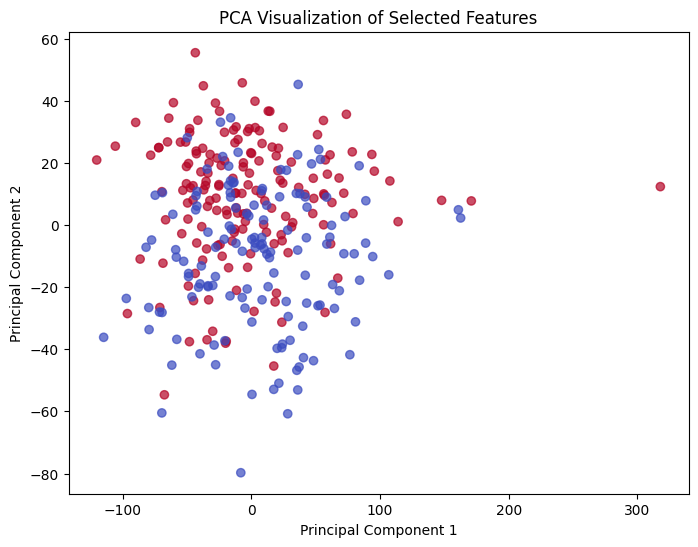

In [35]:
# Applying PCA only for 2D visualization
from sklearn.decomposition import PCA

# Fitting PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_selected)

# Plotting PCA results
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_resampled, cmap='coolwarm', alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization of Selected Features')
plt.show()
